# <img align="left" style="width: 100px;" src="udea_escudo.png">

# Parcial 2 - Sistemas de Control Continuo - 2024-1
### Juan José Díaz - Kevin Jimenez Rincón
CC. 1001456540 - 1001345384

## Modelamiento de la Planta

Inicialmente se plantea un sistema de orden 2, cuyos parámetros de funcionamiento son:

- $M_p = 28\%$
- $t_s = 16 s$

Y su función de transferencia es:

- $G(s) = \frac{\omega_{n}^2} {s^2 + 2\zeta\omega_{n} + \omega_{n}^2}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import control as cont
from control.matlab import *
from plot_zplane import zplane 
import pandas as pd

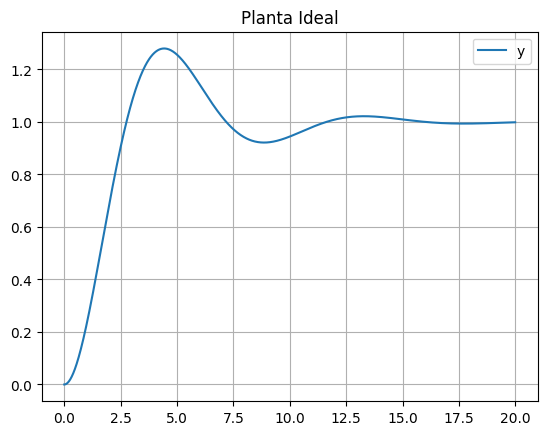

In [4]:
# 1. Planta con los parámetros dados
Mp = 0.28
ts = 16
zita = np.sqrt(((np.log(Mp))**2)/(((np.log(Mp))**2)+np.pi**2))
wn = 4.6/(ts*zita)

A = [[0.,1.],[-wn**2,-2*zita*wn]]
B = [[0],[1.]]
C = [wn**2,0.]
D = 0.

sysCont = ss(A,B,C,D)
tiempo = np.arange(0,20,0.01)
y,Tcont = step(sysCont,tiempo)

plt.plot(Tcont,y,label = 'y')
plt.title("Planta Ideal")
plt.legend()
plt.grid()
plt.show()

### Modelamiento del Sistema en Espacio de Estados

In [5]:
sysCont

<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

### Polos del Sistema Continuo

In [6]:
Polos = sysCont.poles()
print('Polos: ',Polos)

Polos:  [-0.2875+0.70953043j -0.2875-0.70953043j]


### Sistema Discreto Obtenido con Identificación Númerica

Para obtener las matrices discretas del sistema se realizaron dos procedimientos diferentes, uno con la herramienta de identificación de sistemas de MATLAB (Ident), y otro con identificación por mínimos cuadrados. Donde el más preciso fue el obtenido por IDENT. Cuyo resultado fue: 

In [7]:
Tm = (2*np.pi)/(10*np.max(np.abs(Polos)))
print('Tiempo de muestreo recomendado menor a: ', Tm)

Tiempo de muestreo recomendado menor a:  0.8207253142780009


In [8]:
Tm = 0.0488280999999979

Ad = [[1.97016193721059,-0.971651526216715],[1,0]]
Bd = [[1],[0]]
Cd = [0,0.00148209699731618]
Dd = 0

sys_disc = cont.ss(Ad,Bd,Cd,Dd,Tm);

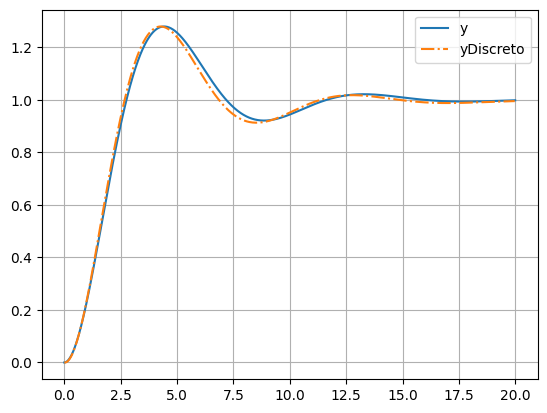

In [9]:
tiempo = np.arange(0,20,Tm)
yDis,T = step(sys_disc,tiempo)

plt.plot(Tcont,y,label = 'y')
plt.plot(T,yDis,'-.',label = 'yDiscreto')
plt.legend()
plt.grid()
plt.show()

In [10]:
sys_disc

<LinearIOSystem:sys[3]:['u[0]']->['y[0]']>

## Control por Realimentación de estados discreto

Un control por Realimentación de estados se considera como un diseño de ubicación de polos, donde se busca que los polos del sistema en lazo cerrado se ubiquen en una posición deseada. Para ello se requiere la representación en espacio de estados del sistema, y el vector de ganancias $K_d$ que permita modificar la posición de los polos de lazo abierto.

<img align="center" style="width: 700px;" src="CRE.png">

### Sistema en Espacio de Estados Discreto

$
x[k+1] = A_d x[k] + B_d u[k]\\
y[k] = C x[k] + D u[k]\\
$

### Ley de Control:

$ u[k] = -K_d x[k] + r\\$

<br>

Y al reemplzar la ley de control en el sistema en espacio de estados discreto se obtiene:


$ x[k+1] = (A_d - B_d K_d) x[k] + B_d r\\ $

Donde $A_d - B_d K_d$ es la matriz de estados del sistema en lazo cerrado $A_{cl}$ también llamada matriz de Estados Controlada.

<br>

### Encontrar $K_d$

El verdadero problema de este método de control es encontrar los valores de $K_d$ que permitan desplazar los polos a la posición deseada. Para ello se despeja de la ecuación del determinante el valor de este vector, de manera que conociendo los polos discretos del sistema mediante la discretización de los polos continuos, se obtiene:

<br>

$ \operatorname{Polos}_z = e^{\operatorname{Polos}_s * Tm }$

$ |z I - (A_d - B_d K_d)| = P_{des}(z) $ → Los autovalores de la matriz $A_d - B_d K_d$ son los polos deseados

<br>




### Parámetros deseados para el controlador

In [11]:
Mp_des = Mp/2
ts_des = ts/2

zita_des = np.sqrt(((np.log(Mp_des))**2)/(((np.log(Mp_des))**2)+np.pi**2))
wn_des = 4.6/(ts_des*zita_des)


polosCont = np.roots([1.,2*zita_des*wn_des,wn_des**2])
print('Polos deseados en S: \n',polosCont)

Polos deseados en S: 
 [-0.575+0.91877522j -0.575-0.91877522j]


In [12]:
polosDis = np.exp(polosCont*Tm)
print('Polos deseados en Z: \n',polosDis)

Polos deseados en Z: 
 [0.97133604+0.04360538j 0.97133604-0.04360538j]


In [13]:
#Vector de Gananacias Kd

Kdis = place(Ad,Bd,polosDis)
print('Kdis: ',Kdis)

Kdis:  [[ 0.02748986 -0.0262564 ]]


### Matrices de estados para el controlador con Realimentación de Estados

In [14]:
Acontrolado = (Ad - Bd@Kdis)
Bcontrolado = np.matrix(Bd)

Ccont = np.matrix(Cd)
Dcont = np.matrix(0)

sysControlado = ss(Acontrolado,Bcontrolado,Ccont,Dcont,dt = Tm)

### Ubicación de Polos y Plano Z

Una anotación importante es que los polos deseados deben ubicarse dentro del círculo unitario en el Plano Z para garantizar que el sistema sea estable. Lo cual se cumple en este caso.

In [15]:
pcont = poles(sysControlado)
print('Polos controlados: ',pcont)

Polos controlados:  [0.97133604+0.04360538j 0.97133604-0.04360538j]


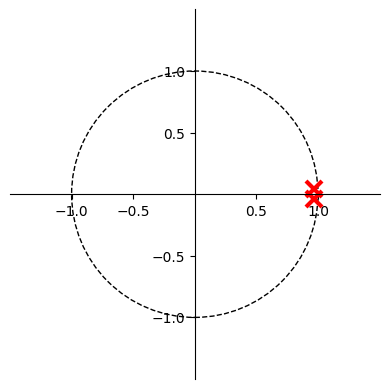

(array([-1.482e+11]), array([0.9715+0.03984658j, 0.9715-0.03984658j]), 1.0)

In [16]:
b = np.array([0,0.00000000000001, 0.001482])
a = np.array([1, -1.943, 0.9454])
zplane(b,a)

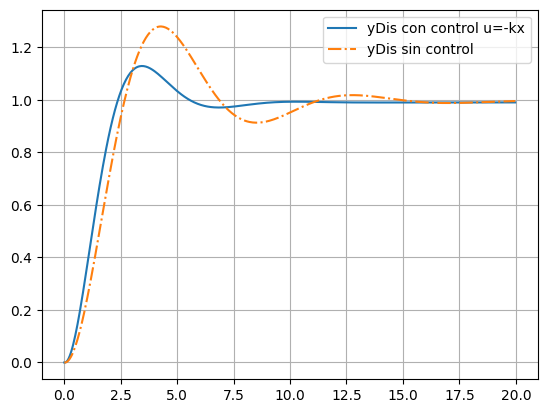

In [17]:
tiempo = np.arange(0,20,Tm)
U = np.ones(len(tiempo))
youtContr, Tcont = step((1.82)*sysControlado,tiempo)

plt.plot(Tcont,youtContr,label = 'yDis con control u=-kx')
plt.plot(T,yDis,'-.',label = 'yDis sin control')
plt.legend()
plt.grid()
plt.show()

Finalmente como resultado se obtiene un sistema con un tiempo de establecimiento de aporximadamente 8s y un sobreimpulso del 15%. Además se debe considerar que este control crea una atenuación o error en el estado estacionario, por lo que se debe tener en cuenta en la implementación del controlador.

## Controlador en Frecuencia

Un controlador en frecuencia es otro tipo de diseño que se hace teniendo en cuenta la fase entre la entrada y la salida del sistema en lazo cerrado. Para que este método de diseño funcione correctamente debe existir un desfase de 180° entre la entrada y la salida del sistema.

Además para asegurar que el sistema sea estable, se debe cumplir que el margen de fase sea positivo. El cual se refiere a la diferencia entre la fase del sistema a la frecuencia que tiene ganancia unitaria(0db) y la fase de -180°.

Finalmente para hallar los valores del controlador se debe estimar la ganancia y la frecuencia de cruce del sistema por -180°, y con estos valores se obtiene el periodo y la ganancia última del controlador. Valores utilizados para sintonizar controladores por métodos como el de Ziegler-Nichols o Chen y Yan.

### Función de Transferencia del sistema continuo

In [18]:
tfc = tf([wn**2],[1,2*zita*wn,wn**2])
tfc

TransferFunction(array([0.58608969]), array([1.        , 0.575     , 0.58608969]))

### Cross-over Frequency and Gain at Cross-over Frequency 

Text(0.5, 1.0, 'Crossover Frequency = 32.4 rad/sec')

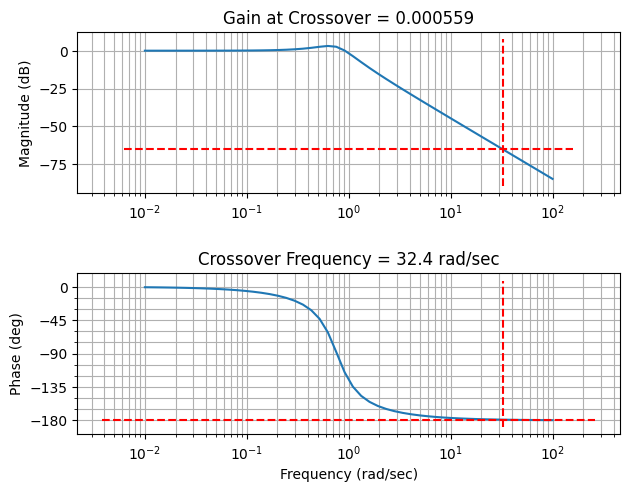

In [19]:
w = np.logspace(-2,2)
mag,phase,omega = cont.matlab.bode(tfc,w);
                                                                    # find the cross-over frequency and gain at cross-over
wc_index = np.argmin(np.abs(phase*(180/np.pi) + 179))               # Index of the Closest Value to -179
wc = omega[wc_index]                                                # Crossover Frequency
gc = np.interp(wc,omega,mag)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

ax1,ax2 = plt.gcf().axes                                            # get subplot axes

plt.sca(ax1)                                                        # magnitude plot
plt.plot(plt.xlim(),[20*np.log10(gc),20*np.log10(gc)],'r--')
plt.plot([wc,wc],plt.ylim(),'r--')
plt.title("Gain at Crossover = {0:.3g}".format(gc))

plt.sca(ax2)                                                        # phase plot
plt.plot(plt.xlim(),[-179,-179],'r--')
plt.plot([wc,wc],plt.ylim(),'r--')
plt.title("Crossover Frequency = {0:.3g} rad/sec".format(wc))

In [20]:
# Margen de Fase

gm_index = np.argmin(abs(20*np.log10(mag)))                                      # Index of the Closest Value to 0
m0 = omega[gm_index]                                                             # (0db) Frequency

# Fase a Frecuencia en(0db) 
pm_index = np.argmin(abs(omega-m0))                                              # Index of the Closest Value to pm     
pm_phase = phase[pm_index]                                                       # Phase at (0db) Frequency

# Margen de Fase
PM = 180 + pm_phase

print('Margen de Fase: ',PM)

Margen de Fase:  179.99018785551843


### Controlador PID


In [21]:
alpha = 0.1 # 10 Veces más pequeño 

Kcu = 1.0/gc
Pu = (2.0*np.pi)/wc

#Ziegler Nichols
#Kp = 0.6*Kcu
#tauI = Pu/2.0
#tauD = Pu/8.0

#Chen y Yan
Kp = 0.27*Kcu 
tauI = 2.40*Pu
tauD = 1.32*Pu

P = Kp * tf([1.0],[1.0])
I = Kp*(1/tauI) * tf([1.0],[1.0,0.0])
D = Kp*(1*tauD) * tf([1.0,0.0],[alpha*tauD,1.0])

Gy = P + I + D

### Respuesta del Controlador

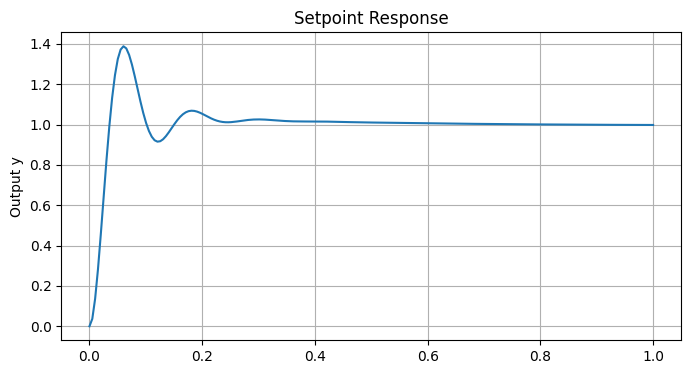

In [22]:
t = np.linspace(0,1,200)
plt.figure(figsize=(8,4))
Hf = feedback(tfc*Gy,1)
yf,t = step(Hf,t)
plt.plot(t,yf)
#plt.plot(plt.xlim(),[1.0,1.0],'r--')
plt.title('Setpoint Response')
plt.ylabel('Output y')
plt.grid()


Al realizar la sintonización por el método de Chen y Yan se obtiene un controlador con un tiempo de establecimiento muy corto y un sobreimpulso en la respuesta del 40% lo cual lo hace aparentemente realizable. Pero al realizar la simulación se observa que requiere de un sobreimpulso de 80 en uno de las variables de estado por lo que en este caso es irrealizable.

<img align="center" style="width: 700px;" src="CY_FC.jpg">

## Montajes Físicos

Para verificar el Correcto funcionamiento del controlador se realizó un montaje físico del sistema, el cual se muestra a continuación.

<img align="center" style="width: 400px;" src="PCB.jpg">

<img align="center" style="width: 400px;" src="Sch.jpg">